In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

from scipy import stats
from sklearn import manifold
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
%store -r samples_data
%store -r sample_285
%store -r sample_313

In [3]:
# 将 No.285 样本和 No.313 样本的修正数据替换到 样本数据 中
for (code_name, i18n_name) in samples_data.keys():
    if (code_name, i18n_name) in sample_285.keys():
        samples_data.iloc[284][(code_name, i18n_name)] = sample_285[(code_name, i18n_name)]
        samples_data.iloc[312][(code_name, i18n_name)] = sample_313[(code_name, i18n_name)]

In [4]:
# 重新查看一下 285号样本
samples_data.iloc[284, 16:23]

S-ZORB.CAL_H2.PV    氢油比          0.273399
S-ZORB.PDI_2102.PV  反应过滤器压差       24.2082
S-ZORB.PT_2801.PV   还原器压力         2.52887
S-ZORB.FC_2801.PV   还原器流化氢气流量     855.883
S-ZORB.TE_2103.PV   反应器上部温度       421.509
S-ZORB.TE_2005.PV   反应器底部温度       421.196
S-ZORB.PT_2101.PV   反应器顶部压力       2.42709
Name: 284, dtype: object

In [5]:
# 重新查看一下 313号样本
samples_data.iloc[312, 16:23]

S-ZORB.CAL_H2.PV    氢油比          0.261936
S-ZORB.PDI_2102.PV  反应过滤器压差       17.1835
S-ZORB.PT_2801.PV   还原器压力         2.41706
S-ZORB.FC_2801.PV   还原器流化氢气流量     850.301
S-ZORB.TE_2103.PV   反应器上部温度       424.969
S-ZORB.TE_2005.PV   反应器底部温度       424.522
S-ZORB.PT_2101.PV   反应器顶部压力        2.3159
Name: 312, dtype: object

In [6]:
samples_data.shape

(325, 370)

In [7]:
# 
# 这里是假设 原料性质 每一个特征都相互之间条件独立 并且符合高斯分布
# 
# 尝试对 样本数据 中 原料性质 进行一个高斯分布检验，如果符合高斯分布，则可以使用3σ检验用来剔除异常样本记录
source_samples = samples_data[samples_data.columns[[x for x in range(2, 9)]]]
for (code_name, i18n_name) in source_samples.keys():
    samples_data_describe = samples_data.describe()
    norm_test = stats.kstest(samples_data[(code_name, i18n_name)], 'norm', (samples_data_describe.loc['mean', (code_name, i18n_name)], samples_data_describe.loc['std', (code_name, i18n_name)]))
    if norm_test.pvalue > 0.05:
        print(f"{'='*10} code_name: {i18n_name} {'='*10}")
        print(f"正态检验 => {norm_test.pvalue}")
        print(f"正态分布检验成功，依据3σ原则进行修正")
        samples_data = samples_data[np.abs(samples_data[(code_name, i18n_name)] - samples_data_describe.loc['mean', (code_name, i18n_name)]) <= 3 * samples_data_describe.loc['std', (code_name, i18n_name)]]

========== code_name: 烯烃,v% ==========
正态检验 => 0.28619137251960225
正态分布检验成功，依据3σ原则进行修正
========== code_name: 芳烃,v% ==========
正态检验 => 0.6575497072348351
正态分布检验成功，依据3σ原则进行修正
========== code_name: 溴值,gBr/100g ==========
正态检验 => 0.1505043280551417
正态分布检验成功，依据3σ原则进行修正
========== code_name: 密度(20℃),kg/m³ ==========
正态检验 => 0.09010267109327164
正态分布检验成功，依据3σ原则进行修正


In [8]:
samples_data.shape

(320, 370)

In [9]:
def reshape_limit_minmax(column_name, df):
    df.drop(df[column_name].idxmax(), inplace=True)
    df.drop(df[column_name].idxmin(), inplace=True)

In [10]:
# 变异系数 $cv_1$
abnormal_ratio1 = 0.3  # 可调参数

In [11]:
# 使用 变异系数 加 最大最小限幅降低 样本数据的 变异系数
source_samples = samples_data[samples_data.columns[[x for x in range(2, 9)]]]
for (code_name, i18n_name) in source_samples.keys():
    samples_data_describe = samples_data.describe()
    temp_ratio = samples_data_describe.loc['mean', (code_name, i18n_name)] / samples_data_describe.loc['std', (code_name, i18n_name)]
    while temp_ratio > abnormal_ratio1:
        reshape_limit_minmax((code_name, i18n_name), samples_data)
        temp_ratio = samples_data[(code_name, i18n_name)].std() / samples_data[(code_name, i18n_name)].mean()
    print(f"原料属性: {i18n_name} 调整后 变异系数：{temp_ratio}")

原料属性: 硫含量,μg/g 调整后 变异系数：0.28057104622365847
原料属性: 辛烷值RON 调整后 变异系数：0.009942092649794898
原料属性: 饱和烃,v%（烷烃+环烷烃） 调整后 变异系数：0.08672328392170767
原料属性: 烯烃,v% 调整后 变异系数：0.19298992178520852
原料属性: 芳烃,v% 调整后 变异系数：0.08168723551438685
原料属性: 溴值,gBr/100g 调整后 变异系数：0.1255508755887609
原料属性: 密度(20℃),kg/m³ 调整后 变异系数：0.005663058788360838


In [12]:
samples_data.shape

(306, 370)

In [13]:
#
# 这里是假设 产品性质 每一个特征都相互之间条件独立 并且符合高斯分布
#
# 尝试对 样本数据 中 产品性质 进行一个高斯分布检验，如果符合高斯分布，则可以使用3σ检验用来剔除异常样本记录
source_samples = samples_data[samples_data.columns[[x for x in range(9, 12)]]]
for (code_name, i18n_name) in source_samples.keys():
    samples_data_describe = samples_data.describe()
    norm_test = stats.kstest(samples_data[(code_name, i18n_name)], 'norm', (samples_data_describe.loc['mean', (code_name, i18n_name)], samples_data_describe.loc['std', (code_name, i18n_name)]))
    if norm_test.pvalue > 0.05:
        print(f"{'='*10} code_name: {i18n_name} {'='*10}")
        print(f"正态检验 => {norm_test.pvalue}")
        print(f"正态分布检验成功，依据3σ原则进行修正")
        samples_data = samples_data[np.abs(samples_data[(code_name, i18n_name)] - samples_data_describe.loc['mean', (code_name, i18n_name)]) <= 3 * samples_data_describe.loc['std', (code_name, i18n_name)]]

========== code_name: 辛烷值RON ==========
正态检验 => 0.07527208590975332
正态分布检验成功，依据3σ原则进行修正


In [14]:
# 修正时间值并按时间进行排序
samples_data.sort_values(("时间", 'Unnamed: 1_level_1'), inplace=True)
samples_data.shape

(306, 370)

In [15]:
# 对目标值进行归一化 （数值-均值）/ 方差 对数据集进行平移操作
samples_data[('产品性质', 'RON损失\n（不是变量）')] = (samples_data[('产品性质', 'RON损失\n（不是变量）')] - samples_data[('产品性质', 'RON损失\n（不是变量）')].mean()) / samples_data[('产品性质', 'RON损失\n（不是变量）')].std()
samples_data[('原料性质', '辛烷值RON')] = (samples_data[('原料性质', '辛烷值RON')] - samples_data[('原料性质', '辛烷值RON')].mean())/samples_data[('原料性质', '辛烷值RON')].std()
samples_data[('原料性质', '硫含量,μg/g')] = (samples_data[('原料性质', '硫含量,μg/g')] - samples_data[('原料性质', '硫含量,μg/g')].mean())/samples_data[('原料性质', '硫含量,μg/g')].std()

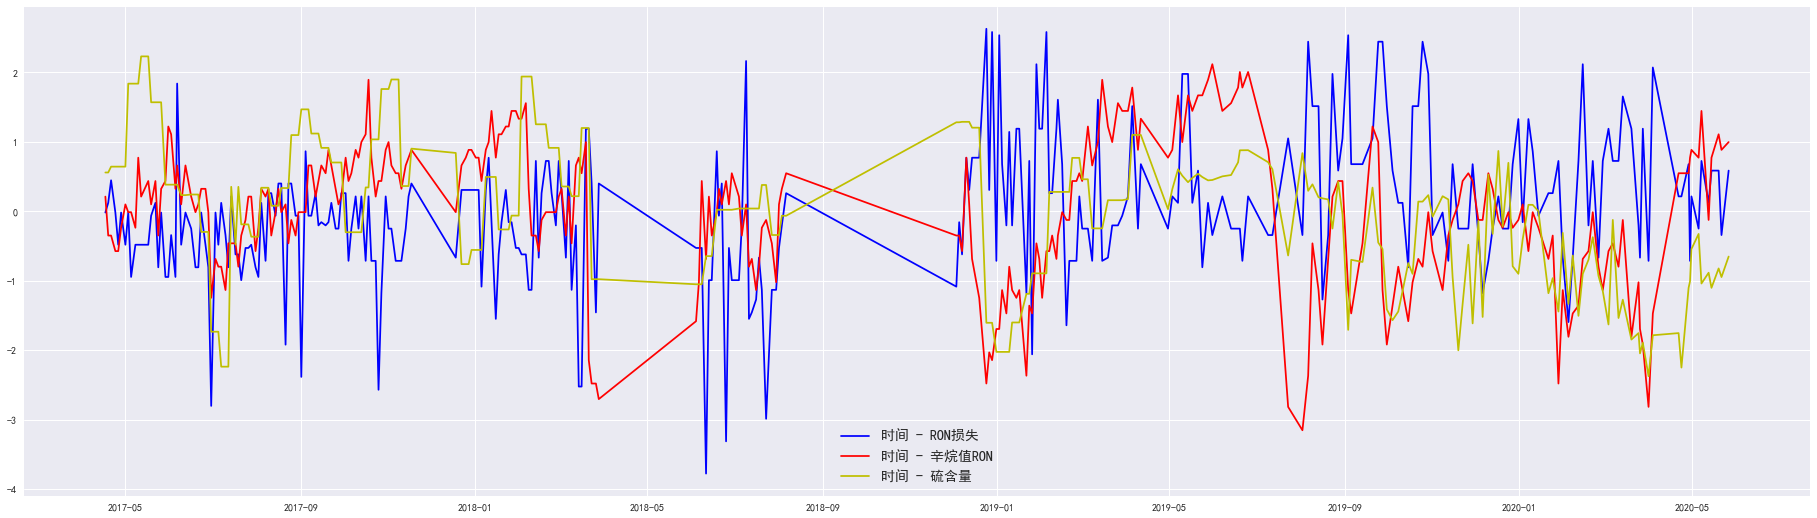

In [16]:
# 查看 产品性质-RON损失 和 时间 && 原料性质-辛烷值RON 相对于 时间 的分布情况
plt.figure(figsize = (32, 9))
plt.plot(samples_data[("时间", 'Unnamed: 1_level_1')], samples_data[('产品性质', 'RON损失\n（不是变量）')], c='b', label="时间 - RON损失")
plt.plot(samples_data[("时间", 'Unnamed: 1_level_1')], samples_data[('原料性质', '辛烷值RON')], c='r', label="时间 - 辛烷值RON")
plt.plot(samples_data[("时间", 'Unnamed: 1_level_1')], samples_data[('原料性质', '硫含量,μg/g')], c='y', label="时间 - 硫含量")
plt.legend(loc="lower center", prop={'size': 14})
plt.show()

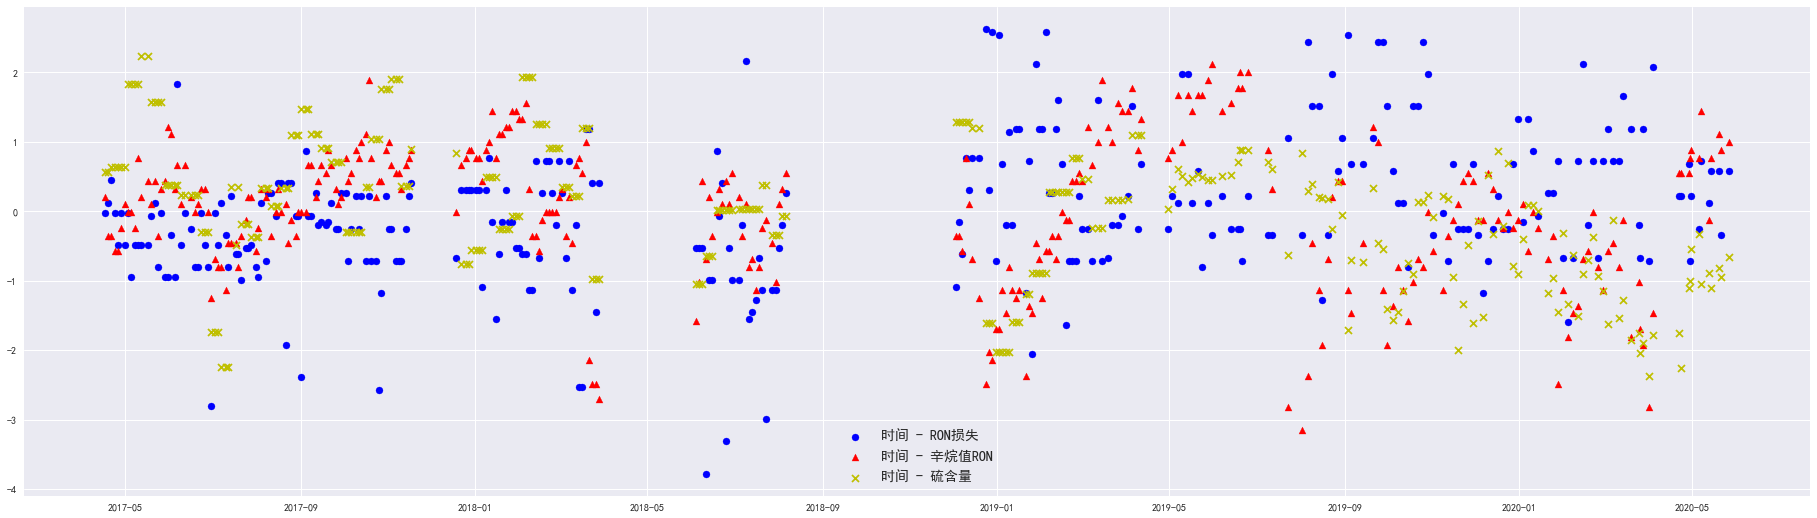

In [17]:
# 查看 产品性质-RON损失 和 时间 && 原料性质-辛烷值RON 相对于 时间 的分布情况
plt.figure(figsize = (32, 9))
plt.scatter([pd.to_datetime(d) for d in samples_data[("时间", 'Unnamed: 1_level_1')]], samples_data[('产品性质', 'RON损失\n（不是变量）')], c='b', marker='o', label="时间 - RON损失")
plt.scatter([pd.to_datetime(d) for d in samples_data[("时间", 'Unnamed: 1_level_1')]], samples_data[('原料性质', '辛烷值RON')], c='r', marker='^', label="时间 - 辛烷值RON")
plt.scatter([pd.to_datetime(d) for d in samples_data[("时间", 'Unnamed: 1_level_1')]], samples_data[('原料性质', '硫含量,μg/g')], c='y', marker='x', label="时间 - 硫含量")
plt.legend(loc="lower center", prop={'size': 14})
plt.show()

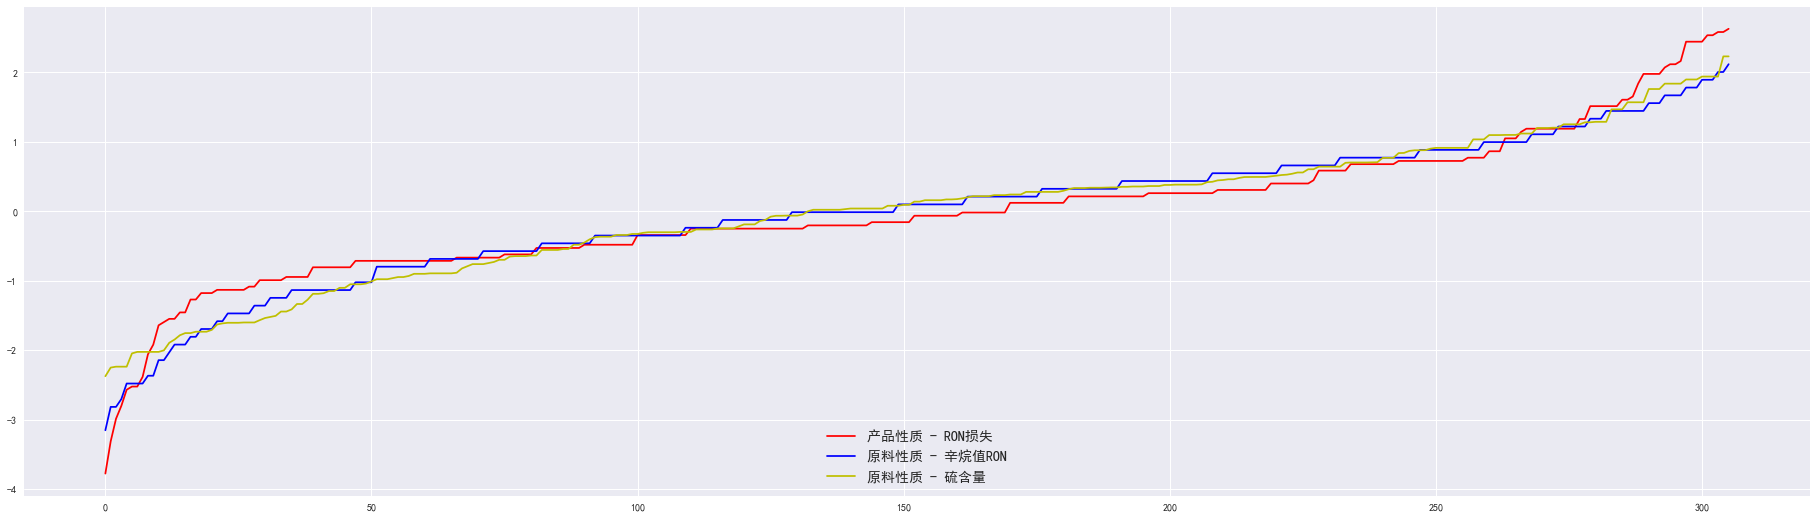

In [18]:
# 查看 产品性质-RON损失 和 原料性质-辛烷值RON 按值大小排序的分布
plt.figure(figsize = (32, 9))
plt.plot([x for x in range(0, samples_data.shape[0])], samples_data[('产品性质', 'RON损失\n（不是变量）')].sort_values(), 'r', label="产品性质 - RON损失")
plt.plot([x for x in range(0, samples_data.shape[0])], samples_data[('原料性质', '辛烷值RON')].sort_values(), 'b', label="原料性质 - 辛烷值RON")
plt.plot([x for x in range(0, samples_data.shape[0])], samples_data[('原料性质', '硫含量,μg/g')].sort_values(), 'y', label="原料性质 - 硫含量")
plt.legend(loc = "lower center", prop={'size': 14})
plt.show()

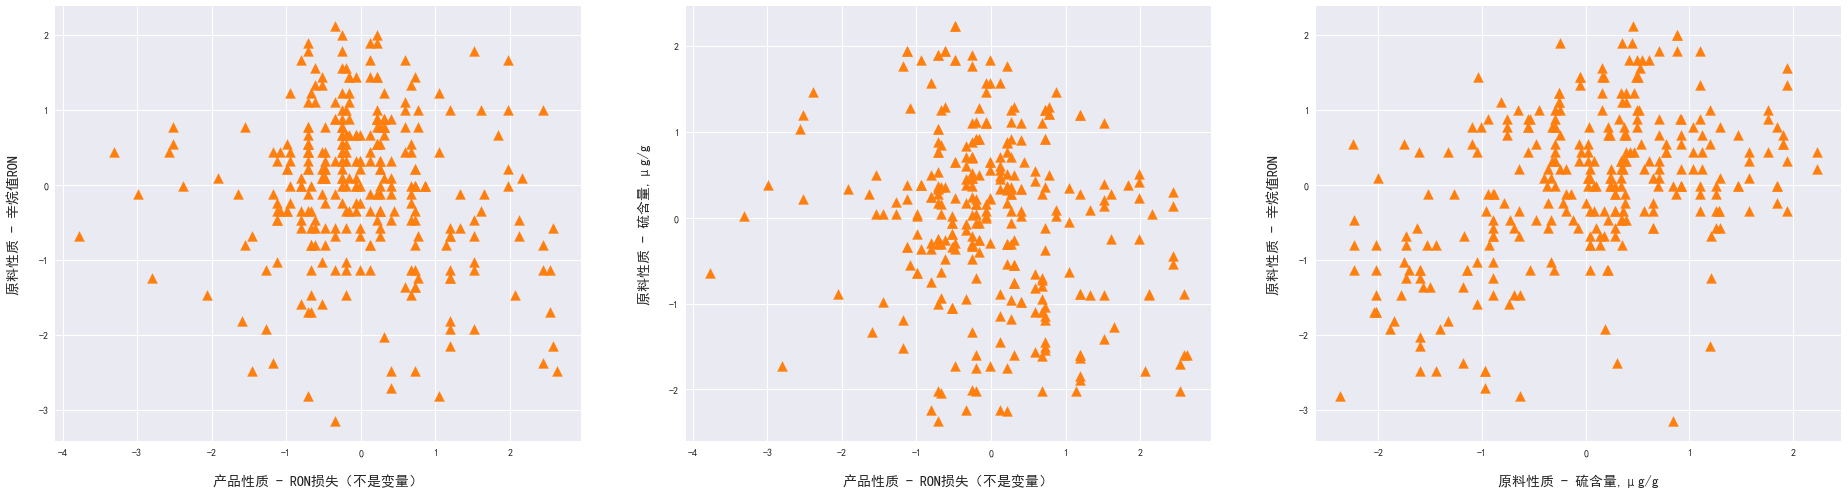

In [19]:
fig = plt.figure(figsize=(32, 8))
plt.subplot(131)
plt.scatter(samples_data[('产品性质', 'RON损失\n（不是变量）')], samples_data[('原料性质', '辛烷值RON')], c="#ff7f0e", marker="^", s=100)
plt.xlabel("产品性质 - RON损失（不是变量）", labelpad=18, fontsize=14)
plt.ylabel("原料性质 - 辛烷值RON", labelpad=18, fontsize=14)
plt.subplot(132)
plt.scatter(samples_data[('产品性质', 'RON损失\n（不是变量）')], samples_data[('原料性质', '硫含量,μg/g')], c="#ff7f0e", marker="^", s=100)
plt.xlabel("产品性质 - RON损失（不是变量）", labelpad=18, fontsize=14)
plt.ylabel("原料性质 - 硫含量,μg/g", labelpad=18, fontsize=14)
plt.subplot(133)
plt.scatter(samples_data[('原料性质', '硫含量,μg/g')], samples_data[('原料性质', '辛烷值RON')], c="#ff7f0e", marker="^", s=100)
plt.xlabel("原料性质 - 硫含量,μg/g", labelpad=18, fontsize=14)
plt.ylabel("原料性质 - 辛烷值RON", labelpad=18, fontsize=14)
plt.show()

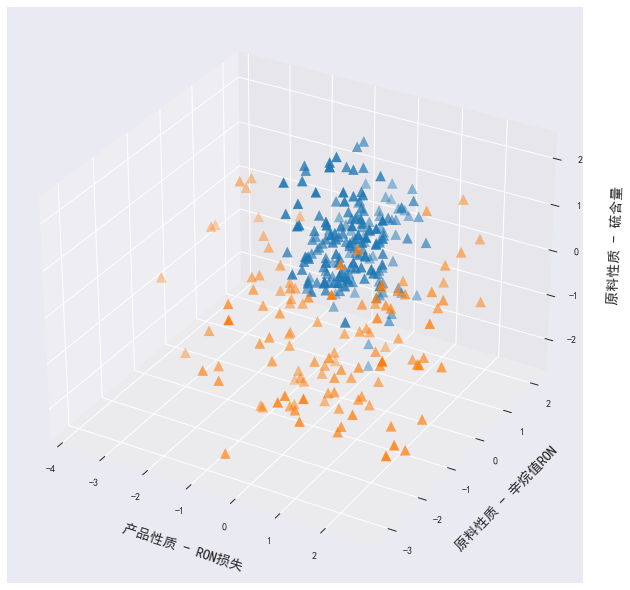

In [20]:
# training gaussian mixture model
gmm = GaussianMixture(n_components=2)
gmm.fit(samples_data[[('产品性质', 'RON损失\n（不是变量）'), ('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g')]])

# predictions from gmm
labels = gmm.predict(samples_data[[('产品性质', 'RON损失\n（不是变量）'), ('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g')]])
frame = pd.DataFrame(samples_data[[('产品性质', 'RON损失\n（不是变量）'), ('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g')]])
frame['cluster'] = labels
frame.columns = [('产品性质', 'RON损失\n（不是变量）'), ('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g'), 'cluster']

fig = plt.figure(figsize=(16, 8))
ax = Axes3D(fig)

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for k in range(0, 8):
    data = frame[frame["cluster"] == k]
    ax.scatter(data[('产品性质', 'RON损失\n（不是变量）')], data[('原料性质', '辛烷值RON')], data[('原料性质', '硫含量,μg/g')], c=color[k], marker="^", s=100)
ax.set_xlabel('产品性质 - RON损失', labelpad=18, fontsize=14)
ax.set_ylabel('原料性质 - 辛烷值RON', labelpad=18, fontsize=14)
ax.set_zlabel('原料性质 - 硫含量', labelpad=18, fontsize=14)
plt.show()

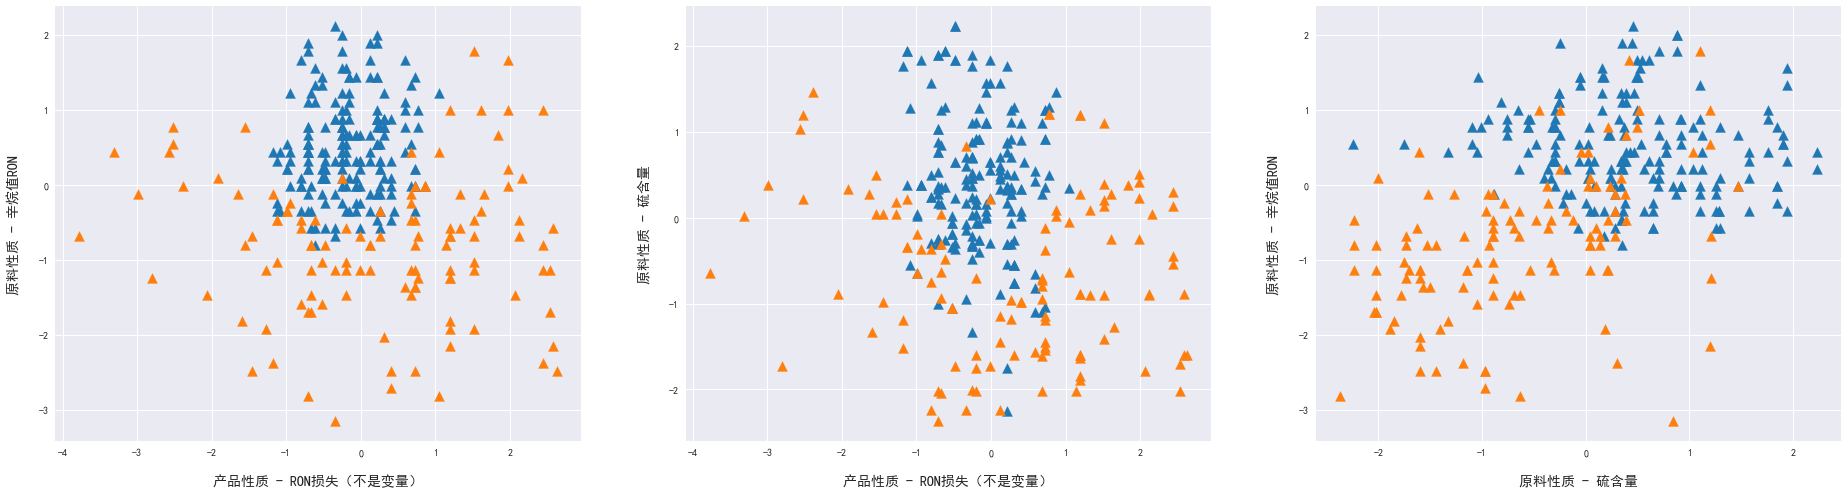

In [21]:
fig = plt.figure(figsize=(32, 8))
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.subplot(131)
for k in range(0, 8):
    data = frame[frame["cluster"] == k]
    plt.scatter(data[('产品性质', 'RON损失\n（不是变量）')], data[('原料性质', '辛烷值RON')], c=color[k], marker="^", s=100)
    plt.xlabel("产品性质 - RON损失（不是变量）", labelpad=18, fontsize=14)
    plt.ylabel("原料性质 - 辛烷值RON", labelpad=18, fontsize=14)
plt.subplot(132)
for k in range(0, 8):
    data = frame[frame["cluster"] == k]
    plt.scatter(data[('产品性质', 'RON损失\n（不是变量）')], data[('原料性质', '硫含量,μg/g')], c=color[k], marker="^", s=100)
    plt.xlabel("产品性质 - RON损失（不是变量）", labelpad=18, fontsize=14)
    plt.ylabel("原料性质 - 硫含量", labelpad=18, fontsize=14)
plt.subplot(133)
for k in range(0, 8):
    data = frame[frame["cluster"] == k]
    plt.scatter(data[('原料性质', '硫含量,μg/g')], data[('原料性质', '辛烷值RON')], c=color[k], marker="^", s=100)
    plt.xlabel("原料性质 - 硫含量", labelpad=18, fontsize=14)
    plt.ylabel("原料性质 - 辛烷值RON", labelpad=18, fontsize=14)
plt.show()

In [22]:
samples_data['cluster'] = labels + 1
samples_data.head(n=5)

样本编号                  时间      原料性质                           \
    Unnamed: 0_level_1  Unnamed: 1_level_1  硫含量,μg/g    辛烷值RON 饱和烃,v%（烷烃+环烷烃）   
324                325 2017-04-17 08:00:00  0.560058  0.212928          46.72   
323                324 2017-04-19 08:00:00  0.560058 -0.347794          46.72   
322                323 2017-04-21 08:00:00  0.644312 -0.347794          47.19   
321                322 2017-04-24 08:00:00  0.644312 -0.572083          47.19   
320                321 2017-04-26 08:00:00  0.644312 -0.572083          47.19   

                                                产品性质  ...  \
     烯烃,v%  芳烃,v% 溴值,gBr/100g 密度(20℃),kg/m³ 硫含量,μg/g  ...   
324  33.78  19.50       45.45         730.0     11.8  ...   
323  33.78  19.50       45.45         730.0      3.6  ...   
322  31.30  21.51       52.02         725.2      3.2  ...   
321  31.30  21.51       52.02         725.2      3.2  ...   
320  31.30  21.51       52.02         725.2      3.2  ...   

    S-ZORB.FT_1006.DACA.PV S-ZORB.FT_5204.DACA.PV  \
             加氢裂化轻石脑油进装置流量              汽油产品去气分流量   
324             8379.94380             158.409230   
323             7998.80235             149.533987   
322             8246.20925             150.095445   
321             8457.86080             148.748365   
320             8328.97475             150.441617   

    S-ZORB.FT_1006.TOTALIZERA.PV S-ZORB.FT_5204.TOTALIZERA.PV  \
                 加氢裂化轻石脑油进装置累积流量                  汽油产品去气分累积流量   
324                  82306629.25                  2103369.350   
323                  82696129.75                  2110959.450   
322                  83087625.75                  2118469.700   
321                  83687113.25                  2129270.425   
320                  84087479.25                  2136687.475   

    S-ZORB.FT_1503.DACA.PV S-ZORB.FT_1503.TOTALIZERA.PV  \
         8.0MPa氢气至循环氢压缩机入口            8.0MPa氢气至循环氢压缩机入口   
324            5419704.000                   1352423.75   
323            4917537.750                   1400663.75   
322            4415371.475                   1448903.75   
321            3662122.000                   1521263.75   
320            3159955.750                   1569503.75   

    S-ZORB.FT_1504.DACA.PV S-ZORB.FT_1504.TOTALIZERA.PV S-ZORB.PC_1001A.PV  \
         8.0MPa氢气至反吹氢压缩机出口            8.0MPa氢气至反吹氢压缩机出口        D101原料缓冲罐压力   
324           -13900.46050                     445996.8        -120.560472   
323           -12373.27275                     569836.8        -120.047287   
322           -10846.08550                     693676.8        -119.534108   
321            -8555.30420                     879436.8        -118.764337   
320            -7028.11670                    1003276.5        -118.251152   

    cluster  
             
324       1  
323       1  
322       1  
321       1  
320       1  

[5 rows x 371 columns]

In [23]:
# 查询 样本数据 的 零值占比
samples_nonzeroratio = samples_data.iloc[:, 2:].astype(bool).sum(axis=0) / samples_data.shape[0]
samples_dummy_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] != 1.0:
        print(f"Missing Value Ratio: {code_name}[{i18n_name}]:  => {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_dummy_columns.append((code_name, i18n_name))

Missing Value Ratio: S-ZORB.FC_2301.PV[D105流化氢气流量]:  => 0.5718954248366013
Missing Value Ratio: S-ZORB.FT_9301.PV[蒸汽进装置流量]:  => 0.9869281045751634
Missing Value Ratio: S-ZORB.FT_1501.PV[新氢进装置流量]:  => 0.12091503267973856
Missing Value Ratio: S-ZORB.FT_5104.PV[轻烃出装置流量]:  => 0.6111111111111112
Missing Value Ratio: S-ZORB.FT_9101.PV[污油出装置]:  => 0.5947712418300654
Missing Value Ratio: S-ZORB.FT_9402.PV[非净化风进装置流量]:  => 0.9967320261437909
Missing Value Ratio: S-ZORB.FT_1002.PV[1#催化汽油进装置流量]:  => 0.5620915032679739
Missing Value Ratio: S-ZORB.FT_1003.PV[2#催化汽油进装置流量]:  => 0.9901960784313726
Missing Value Ratio: S-ZORB.FT_1004.PV[3#催化汽油进装置流量]:  => 0.954248366013072
Missing Value Ratio: S-ZORB.FC_1202.PV[D121顶去放火炬流量]:  => 0.3235294117647059
Missing Value Ratio: S-ZORB.FC_3103.PV[再生冷氮气流量]:  => 0.3431372549019608
Missing Value Ratio: S-ZORB.FT_1002.TOTAL[0]:  => 0.4411764705882353
Missing Value Ratio: S-ZORB.FT_1501.TOTAL[新氢进装置流量]:  => 0.6078431372549019
Missing Value Ratio: S-ZORB.FT_5102.PV[0]:  =

检查下面的变量取值范围是否包含0

+ ('S-ZORB.FC_2301.PV', 'D105流化氢气流量')                    0-350
+ ('S-ZORB.FT_1501.PV', '新氢进装置流量')                      0-3500
+ ('S-ZORB.FT_5104.PV', '轻烃出装置流量')                     0-3500
+ ('S-ZORB.FT_9101.PV', '污油出装置')                         0-85
+ ('S-ZORB.FT_1002.PV', '1#催化汽油进装置流量')               0-140
+ ('S-ZORB.FT_1004.PV', '3#催化汽油进装置流量')                 0-90
+ ('S-ZORB.FC_1202.PV', 'D121顶去放火炬流量')                0-300
+ ('S-ZORB.FC_3103.PV', '再生冷氮气流量')                     0-80
+ ('S-ZORB.FT_1002.TOTAL', 0)                            0-620
+ ('S-ZORB.FT_1501.TOTAL', '新氢进装置流量')                0-55000000
+ ('S-ZORB.FT_5102.PV', 0)                                   0-450
+ ('S-ZORB.FT_2901.DACA', 'D-109松动风流量'),                   0-30
+ ('S-ZORB.FT_2002.DACA', '热循环气去R101底提升气管流量')        0-400
+ ('S-ZORB.FC_1104.DACA', '进料调节阀旁路流量')                  0-1
+ ('S-ZORB.FT_2803.DACA', '紧急氢气去D-102流量')                0-3
+ ('S-ZORB.FT_1502.DACA', '补充氢压缩机出口返回管流量')          0-2500
+ ('S-ZORB.FT_3702.DACA', '闭锁料斗H2过滤器出口气流量')           0-60
+ ('S-ZORB.TEX_3103A.DACA', 'EH-102加热元件/A束温度')           0-100
+ ('S-ZORB.FT_5102.DACA.PV', 'D-201含硫污水排量')              0-420
+ ('S-ZORB.FT_1006.DACA.PV', '加氢裂化轻石脑油进装置流量')       0-12000
+ ('S-ZORB.FT_5204.DACA.PV', '汽油产品去气分流量')               0-2500

即存在零值的属性其值域都包含了零，但是考虑到上述属性值值域范围在边界的情况下才为0，因此不考虑其取零值的情况，只作为缺失的情况进行考虑

<AxesSubplot:>

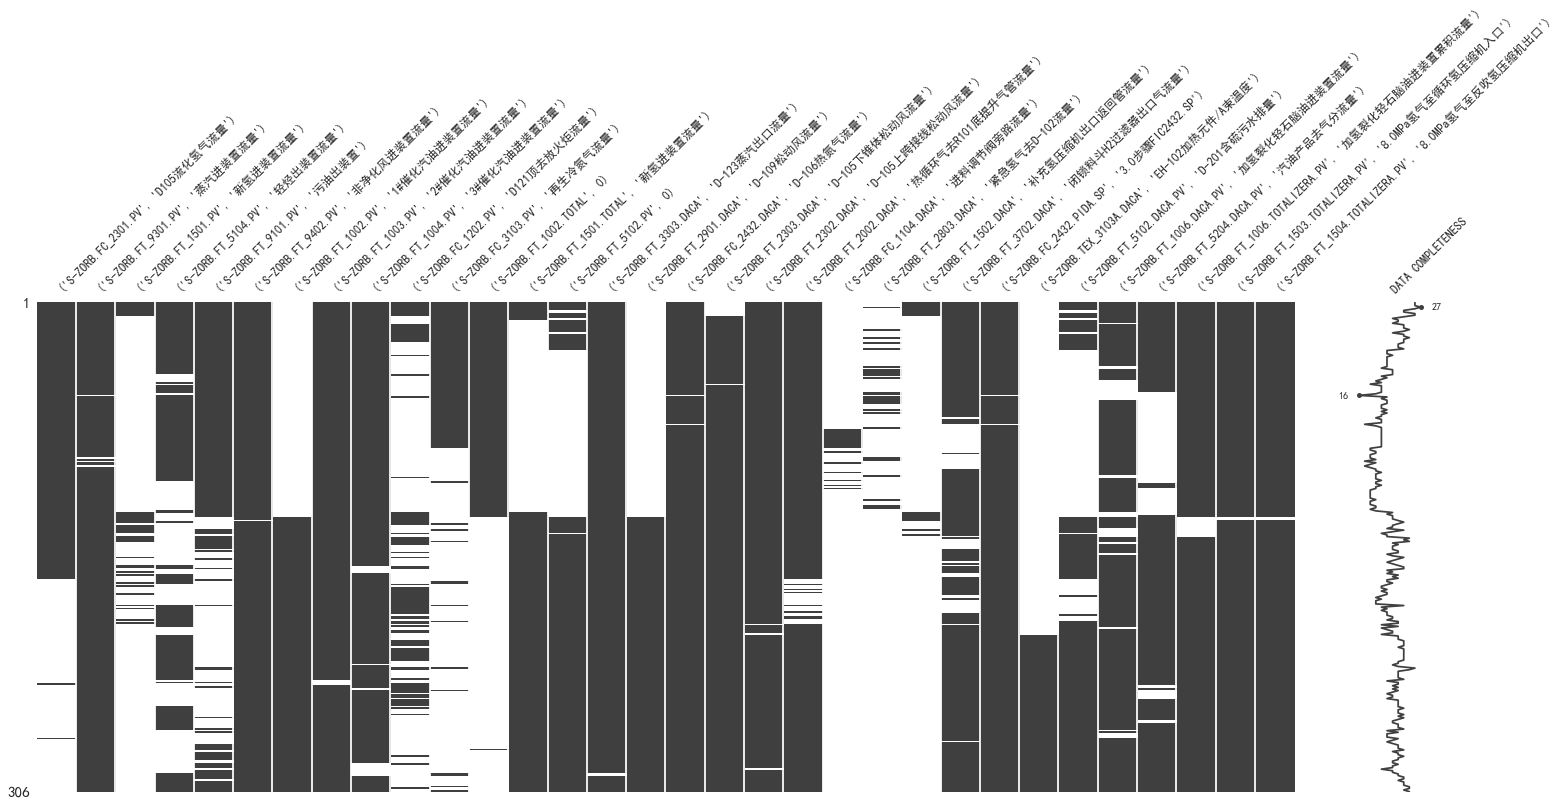

In [24]:
# 可视化呈现 样本数据 中属性中属性值存在零值的属性的分布
msno.matrix(samples_data[samples_dummy_columns].replace(0, np.NaN), figsize=(25, 9), fontsize=12, labels=True)

In [25]:
# 缺失值比例
missing_ratio2 = 0.95  # 可调参数

In [26]:
# 对 缺失值较多属性值 的属性进行丢弃 对 缺失值较少属性值 的属性进行插值
samples_delete_columns = []
samples_insert_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] < missing_ratio2:
        # print(f"code_name: {code_name} => nonzero_ratio: {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_delete_columns.append((code_name, i18n_name))
    elif missing_ratio2 <= samples_nonzeroratio[(code_name, i18n_name)] < 1:
        samples_insert_columns.append((code_name, i18n_name))
samples_data = samples_data.drop(columns=samples_delete_columns, axis=1)
print(f"可以直接进行删除的特征：\n {samples_delete_columns}")
print(f"{'='* 80}")
print(f"需要进行数值填充的特征：\n {samples_insert_columns}")

可以直接进行删除的特征：
 [('S-ZORB.FC_2301.PV', 'D105流化氢气流量'), ('S-ZORB.FT_1501.PV', '新氢进装置流量'), ('S-ZORB.FT_5104.PV', '轻烃出装置流量'), ('S-ZORB.FT_9101.PV', '污油出装置'), ('S-ZORB.FT_1002.PV', '1#催化汽油进装置流量'), ('S-ZORB.FC_1202.PV', 'D121顶去放火炬流量'), ('S-ZORB.FC_3103.PV', '再生冷氮气流量'), ('S-ZORB.FT_1002.TOTAL', 0), ('S-ZORB.FT_1501.TOTAL', '新氢进装置流量'), ('S-ZORB.FT_5102.PV', 0), ('S-ZORB.FT_2901.DACA', 'D-109松动风流量'), ('S-ZORB.FT_2002.DACA', '热循环气去R101底提升气管流量'), ('S-ZORB.FC_1104.DACA', '进料调节阀旁路流量'), ('S-ZORB.FT_2803.DACA', '紧急氢气去D-102流量'), ('S-ZORB.FT_1502.DACA', '补充氢压缩机出口返回管流量'), ('S-ZORB.FT_3702.DACA', '闭锁料斗H2过滤器出口气流量'), ('S-ZORB.TEX_3103A.DACA', 'EH-102加热元件/A束温度'), ('S-ZORB.FT_5102.DACA.PV', 'D-201含硫污水排量'), ('S-ZORB.FT_1006.DACA.PV', '加氢裂化轻石脑油进装置流量'), ('S-ZORB.FT_5204.DACA.PV', '汽油产品去气分流量')]
需要进行数值填充的特征：
 [('S-ZORB.FT_9301.PV', '蒸汽进装置流量'), ('S-ZORB.FT_9402.PV', '非净化风进装置流量'), ('S-ZORB.FT_1003.PV', '2#催化汽油进装置流量'), ('S-ZORB.FT_1004.PV', '3#催化汽油进装置流量'), ('S-ZORB.FT_3303.DACA', 'D-123蒸汽出口流量'), ('S-ZORB.FC_2432.DACA'

<AxesSubplot:>

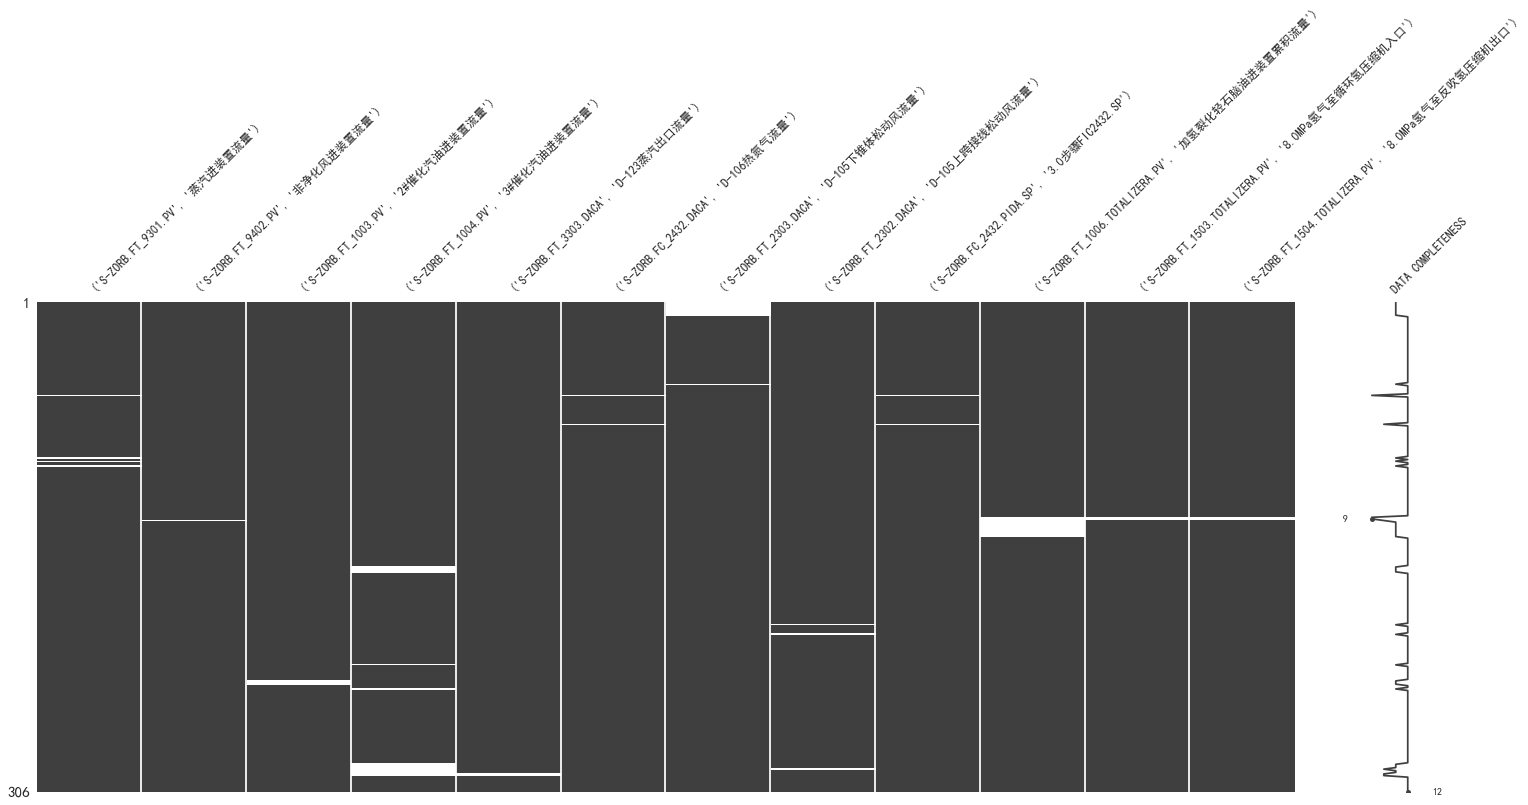

In [27]:
# 可视化呈现 样本数据 中属性中属性值需要进行填充的情况
msno.matrix(samples_data[samples_insert_columns].replace(0, np.NaN), figsize=(25, 9), fontsize=12, labels=True)

In [28]:
# 使用 线性插值的方式 对缺失的属性值进行插值操作
samples_data = samples_data.replace(0, np.NaN).interpolate("nearest")

In [29]:
print(samples_data[samples_data['cluster'] == 1].shape[0])
print(samples_data[samples_data['cluster'] == 2].shape[0])

189
117


In [30]:
# 相关系数 $cc_{1}$
threshold = 0.8  # 可调参数

In [31]:
fix_samples_data = samples_data
%store threshold
%store fix_samples_data
cluster_1st = samples_data[samples_data['cluster'] == 1]
%store cluster_1st
cluster_2nd = samples_data[samples_data['cluster'] == 2]
%store cluster_2nd

Stored 'threshold' (float)
Stored 'fix_samples_data' (DataFrame)
Stored 'cluster_1st' (DataFrame)
Stored 'cluster_2nd' (DataFrame)
